In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [48]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [49]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [50]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
test = test[test['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

D:\AnaconDA\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [51]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000,842206.000000,575773.000000,575773.000000,844392.000000,421085.000000,421085.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580,5457.979627,7.224879,2008.697747,0.498684,23.253426,2011.754019
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103,7809.437311,3.210144,5.978048,0.499999,14.100569,1.660962
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000,710.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,2320.000000,8.000000,2010.000000,0.000000,22.000000,2012.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000,6890.000000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


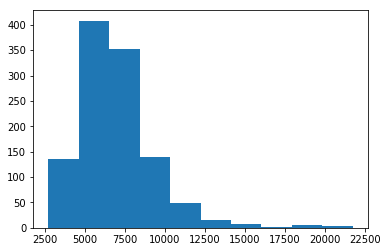

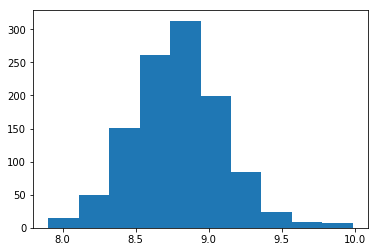

In [52]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [53]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [54]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        data.drop(['Store','Open','Date','Customers','PromoInterval'],axis=1,inplace=True)
    else:
        data.drop(['Id','Store','Open','Date','PromoInterval'],axis=1,inplace=True)
    print(data.columns)

In [55]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
Index(['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


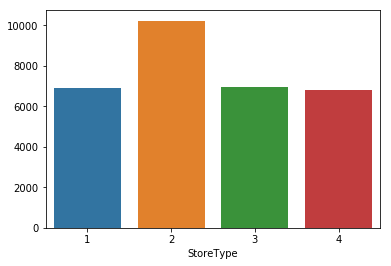

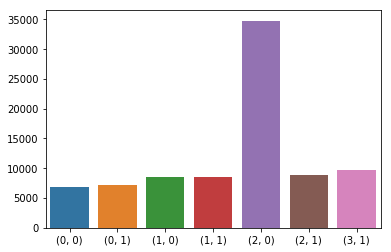

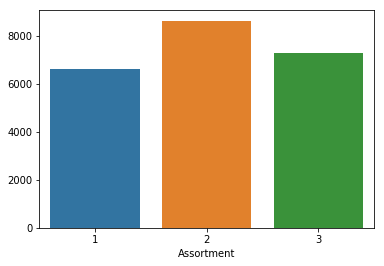

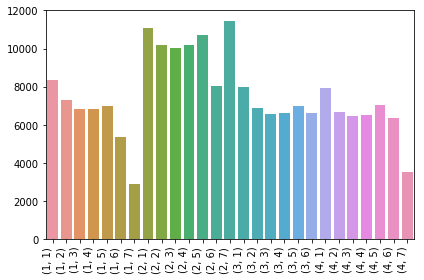

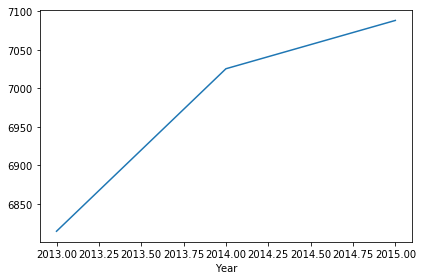

In [56]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()
StateOPen_gp = train.groupby(['StateHoliday','SchoolHoliday'])['Sales'].agg('mean')
sns.barplot(StateOPen_gp.index,StateOPen_gp.values)
plt.show()
As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [57]:
# from sklearn.ensemble import GradientBoostingRegressor
# print(train.size)
# train.dropna(axis=0,how='any',inplace=True)
# print(train.size)

In [58]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

D:\AnaconDA\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


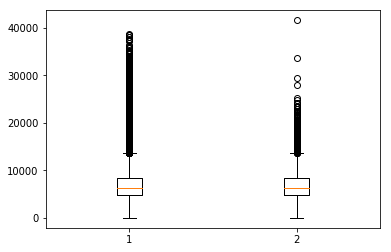

In [59]:
plt.boxplot([Y_train,Y_valid])
plt.show()

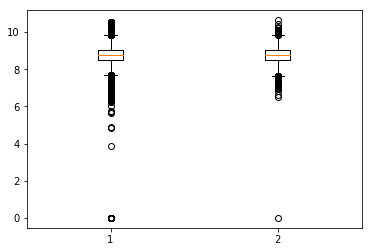

In [60]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [61]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

epohs = 20

In [64]:
params = {"objective": "reg:linear",
          "eta": 0.15,
          "max_depth": 12,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

dtrain = xgb.DMatrix(X_train, Y_train)
dvalid = xgb.DMatrix(X_valid, Y_valid)
#dtest = xgb.DMatrix(test)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)

[0]	eval-rmse:7.02639	train-rmse:7.0309	eval-rmspe:0.999145	train-rmspe:0.999167
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:5.9757	train-rmse:5.97971	eval-rmspe:0.997334	train-rmspe:0.997363
[2]	eval-rmse:5.08271	train-rmse:5.08608	eval-rmspe:0.993358	train-rmspe:0.993396
[3]	eval-rmse:4.32402	train-rmse:4.32712	eval-rmspe:0.985735	train-rmspe:0.985794
[4]	eval-rmse:3.67966	train-rmse:3.68213	eval-rmspe:0.972857	train-rmspe:0.972934
[5]	eval-rmse:3.13258	train-rmse:3.13461	eval-rmspe:0.953131	train-rmspe:0.953246
[6]	eval-rmse:2.66724	train-rmse:2.66927	eval-rmspe:0.925658	train-rmspe:0.925838
[7]	eval-rmse:2.27266	train-rmse:2.27429	eval-rmspe:0.890117	train-rmspe:0.890395
[8]	eval-rmse:1.93755	train-rmse:1.93891	eval-rmspe:0.846943	train-rmspe:0.847366
[9]	eval-rmse:1.65379	train-rmse:1.65452	eval-rmspe:0.797449	train-rmspe:0.798071
[10]	eval-rmse:1.41305	train-rmse:1

[96]	eval-rmse:0.144302	train-rmse:0.121369	eval-rmspe:0.125422	train-rmspe:0.148959
[97]	eval-rmse:0.144252	train-rmse:0.12124	eval-rmspe:0.125366	train-rmspe:0.146893
[98]	eval-rmse:0.144096	train-rmse:0.12099	eval-rmspe:0.1252	train-rmspe:0.146656
[99]	eval-rmse:0.144009	train-rmse:0.120751	eval-rmspe:0.125121	train-rmspe:0.146501
[100]	eval-rmse:0.143905	train-rmse:0.120555	eval-rmspe:0.124977	train-rmspe:0.146313
[101]	eval-rmse:0.143803	train-rmse:0.120364	eval-rmspe:0.124872	train-rmspe:0.146152
[102]	eval-rmse:0.143611	train-rmse:0.120046	eval-rmspe:0.12461	train-rmspe:0.145595
[103]	eval-rmse:0.143303	train-rmse:0.119616	eval-rmspe:0.124245	train-rmspe:0.144163
[104]	eval-rmse:0.142951	train-rmse:0.119128	eval-rmspe:0.12379	train-rmspe:0.14373
[105]	eval-rmse:0.142921	train-rmse:0.119088	eval-rmspe:0.123769	train-rmspe:0.143664
[106]	eval-rmse:0.142659	train-rmse:0.118633	eval-rmspe:0.123388	train-rmspe:0.143162
[107]	eval-rmse:0.142666	train-rmse:0.118403	eval-rmspe:0.123258	

[192]	eval-rmse:0.133405	train-rmse:0.096736	eval-rmspe:0.11153	train-rmspe:0.116225
[193]	eval-rmse:0.13352	train-rmse:0.096428	eval-rmspe:0.111581	train-rmspe:0.114136
[194]	eval-rmse:0.133477	train-rmse:0.09626	eval-rmspe:0.111499	train-rmspe:0.113989
[195]	eval-rmse:0.13351	train-rmse:0.096131	eval-rmspe:0.111413	train-rmspe:0.112792
[196]	eval-rmse:0.133518	train-rmse:0.096049	eval-rmspe:0.111399	train-rmspe:0.11273
[197]	eval-rmse:0.133488	train-rmse:0.095931	eval-rmspe:0.111333	train-rmspe:0.113014
[198]	eval-rmse:0.133419	train-rmse:0.095779	eval-rmspe:0.111229	train-rmspe:0.112888
[199]	eval-rmse:0.133388	train-rmse:0.095636	eval-rmspe:0.111185	train-rmspe:0.112709
[200]	eval-rmse:0.133384	train-rmse:0.095553	eval-rmspe:0.111132	train-rmspe:0.11257
[201]	eval-rmse:0.133318	train-rmse:0.095392	eval-rmspe:0.111067	train-rmspe:0.112452
[202]	eval-rmse:0.133273	train-rmse:0.095249	eval-rmspe:0.111014	train-rmspe:0.112353
[203]	eval-rmse:0.133222	train-rmse:0.095002	eval-rmspe:0.11

[288]	eval-rmse:0.131809	train-rmse:0.085074	eval-rmspe:0.109024	train-rmspe:0.100006
[289]	eval-rmse:0.131843	train-rmse:0.085004	eval-rmspe:0.10903	train-rmspe:0.099549
[290]	eval-rmse:0.131791	train-rmse:0.084743	eval-rmspe:0.108815	train-rmspe:0.095372
[291]	eval-rmse:0.131699	train-rmse:0.084653	eval-rmspe:0.108691	train-rmspe:0.095215
[292]	eval-rmse:0.131695	train-rmse:0.084584	eval-rmspe:0.108677	train-rmspe:0.095166
[293]	eval-rmse:0.131719	train-rmse:0.084528	eval-rmspe:0.108685	train-rmspe:0.095136
[294]	eval-rmse:0.131696	train-rmse:0.084431	eval-rmspe:0.108675	train-rmspe:0.093964
[295]	eval-rmse:0.131687	train-rmse:0.08427	eval-rmspe:0.108711	train-rmspe:0.090466
[296]	eval-rmse:0.13167	train-rmse:0.084195	eval-rmspe:0.108659	train-rmspe:0.090374
[297]	eval-rmse:0.131629	train-rmse:0.08408	eval-rmspe:0.108626	train-rmspe:0.090282
[298]	eval-rmse:0.13166	train-rmse:0.084032	eval-rmspe:0.108645	train-rmspe:0.090259
[299]	eval-rmse:0.131647	train-rmse:0.083916	eval-rmspe:0.1

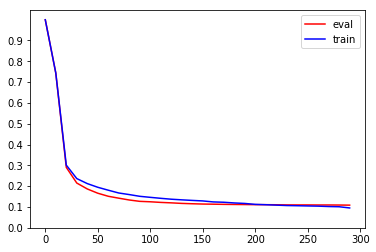

In [65]:
evaldata = ret['eval']['rmspe'][0:300:10]
traindata = ret['train']['rmspe'][0:300:10]
plt.plot(range(0,300,10),evaldata,color='red',label="eval")
plt.plot(range(0,300,10),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()